In [80]:
# Import relevant libraries
import os
import pandas as pd

from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters, TEMPLATE_TIME_SETUP_DICT

import numpy as np

from SALib.sample import saltelli

from comparative_gsa.sample_input_space import sample_input_space

import json

from ModularCirc import BatchRunner

from comparative_gsa.simulate_data import simulate_data
from comparative_gsa.calculate_output_features import calculate_output_features

from SALib.analyze.sobol import analyze

In [81]:
param_path = '../inputs/parameters_naghavi_constrained_fixed_T_v_tot.json'
# Get the filename from the path, without extension
param_filename = os.path.splitext(os.path.basename(param_path))[0]

n_samples = 10**7

In [82]:
# Set up the batch runner

## read in save parameters to the folder where simulations r saved.
with open(param_path, 'r') as f:
    params = json.load(f)

# Set up the batch runner
br = BatchRunner('Sobol', 0) # why are we using 'Sobol' here?
br.setup_sampler(param_path)
br.sample(n_samples)

/Users/syonis/project/comparative-gsa/venv/lib/python3.12/site-packages/ModularCirc/_BatchRunner.py:59: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples  = self._sampler.random(nsamples)


In [83]:
br.samples

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max,T,v_tot
0,305.576111,0.364705,1047.778645,2.796825,7.379755,116.738799,5.767604,3.872886,0.253016,0.650535,...,150,225,25,150,0,420,25,280,800,5000
1,239.201979,0.294212,1290.672647,3.257753,10.025982,101.463371,6.617964,4.674997,0.357100,0.503905,...,150,225,25,150,0,420,25,280,800,5000
2,218.335616,0.324832,910.186916,2.417528,10.382382,94.085593,5.249952,4.504283,0.334988,0.421357,...,150,225,25,150,0,420,25,280,800,5000
3,277.901886,0.254335,1145.884560,3.622402,8.282241,137.229613,7.212086,3.251764,0.293604,0.550802,...,150,225,25,150,0,420,25,280,800,5000
4,273.455547,0.305361,1370.442680,3.441763,8.862728,123.493007,4.754028,4.111263,0.314531,0.522093,...,150,225,25,150,0,420,25,280,800,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,272.889215,0.264726,1181.212276,3.145335,11.151269,101.929542,6.357273,4.898672,0.316337,0.604888,...,150,225,25,150,0,420,25,280,800,5000
9999996,276.436968,0.370886,1405.427471,3.337281,10.502391,88.226088,5.774414,4.010113,0.294270,0.504489,...,150,225,25,150,0,420,25,280,800,5000
9999997,218.824582,0.281569,1072.517998,2.714316,8.102875,130.057068,6.611545,4.745910,0.333168,0.650052,...,150,225,25,150,0,420,25,280,800,5000
9999998,237.699367,0.335718,1259.645360,3.705054,7.735420,122.165883,5.243143,4.397085,0.357638,0.550042,...,150,225,25,150,0,420,25,280,800,5000


In [84]:
br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.v_ref': (6.75, 11.25),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.v_ref': (7.5, 12.5),
 'lv.k_pas': (0.00999, 0.045)}

In [85]:
# Now, generate samples for sensitivity analysis by taking the keys of _parameters_2_sample and turning into a list
relevant_columns = list(br._parameters_2_sample.keys())
relevant_columns

['ao.r',
 'ao.c',
 'art.r',
 'art.c',
 'ven.r',
 'ven.c',
 'av.r',
 'mv.r',
 'la.E_pas',
 'la.E_act',
 'la.v_ref',
 'la.k_pas',
 'lv.E_pas',
 'lv.E_act',
 'lv.v_ref',
 'lv.k_pas']

In [86]:
problem = {
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : br.samples[relevant_columns].describe().loc[['min', 'max']].T.values
}

In [ ]:
param_values = saltelli.sample(problem, 1024
, calc_second_order=True)
param_values.shape

/var/folders/fj/g5601sws7zx_c6t8mk9t4x580000gq/T/ipykernel_90712/1575099066.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024, calc_second_order=True)


(34816, 16)

In [88]:
param_values

array([[1.95190441e+02, 2.81469723e-01, 1.09561156e+03, ...,
        2.75756840e+00, 8.16162142e+00, 3.99912428e-02],
       [3.06147456e+02, 2.81469723e-01, 1.09561156e+03, ...,
        2.75756840e+00, 8.16162142e+00, 3.99912428e-02],
       [1.95190441e+02, 2.54663085e-01, 1.09561156e+03, ...,
        2.75756840e+00, 8.16162142e+00, 3.99912428e-02],
       ...,
       [2.65395509e+02, 3.48559562e-01, 9.05548120e+02, ...,
        2.83813480e+00, 9.94384771e+00, 2.45034224e-02],
       [2.65395509e+02, 3.48559562e-01, 9.05548120e+02, ...,
        2.83813480e+00, 7.87841834e+00, 3.37345736e-02],
       [2.65395509e+02, 3.48559562e-01, 9.05548120e+02, ...,
        2.83813480e+00, 7.87841834e+00, 2.45034224e-02]])

In [89]:
param_values = pd.DataFrame(param_values) 

param_values.columns = relevant_columns

param_values

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas
0,195.190441,0.281470,1095.611563,2.980225,9.257080,132.801098,5.225098,4.279175,0.329517,0.597131,10.447998,0.070413,1.103271,2.757568,8.161621,0.039991
1,306.147456,0.281470,1095.611563,2.980225,9.257080,132.801098,5.225098,4.279175,0.329517,0.597131,10.447998,0.070413,1.103271,2.757568,8.161621,0.039991
2,195.190441,0.254663,1095.611563,2.980225,9.257080,132.801098,5.225098,4.279175,0.329517,0.597131,10.447998,0.070413,1.103271,2.757568,8.161621,0.039991
3,195.190441,0.281470,1146.697980,2.980225,9.257080,132.801098,5.225098,4.279175,0.329517,0.597131,10.447998,0.070413,1.103271,2.757568,8.161621,0.039991
4,195.190441,0.281470,1095.611563,2.769287,9.257080,132.801098,5.225098,4.279175,0.329517,0.597131,10.447998,0.070413,1.103271,2.757568,8.161621,0.039991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34811,265.395509,0.348560,905.548120,2.304932,8.360596,91.088112,4.782715,4.505395,0.367456,0.500452,7.890381,0.021237,1.042236,2.838135,7.878418,0.024503
34812,265.395509,0.348560,905.548120,2.304932,8.360596,91.088112,4.782715,4.505395,0.367456,0.500452,7.890381,0.021237,1.015381,3.731689,7.878418,0.024503
34813,265.395509,0.348560,905.548120,2.304932,8.360596,91.088112,4.782715,4.505395,0.367456,0.500452,7.890381,0.021237,1.015381,2.838135,9.943848,0.024503
34814,265.395509,0.348560,905.548120,2.304932,8.360596,91.088112,4.782715,4.505395,0.367456,0.500452,7.890381,0.021237,1.015381,2.838135,7.878418,0.033735


In [90]:
br._samples

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max,T,v_tot
0,305.576111,0.364705,1047.778645,2.796825,7.379755,116.738799,5.767604,3.872886,0.253016,0.650535,...,150,225,25,150,0,420,25,280,800,5000
1,239.201979,0.294212,1290.672647,3.257753,10.025982,101.463371,6.617964,4.674997,0.357100,0.503905,...,150,225,25,150,0,420,25,280,800,5000
2,218.335616,0.324832,910.186916,2.417528,10.382382,94.085593,5.249952,4.504283,0.334988,0.421357,...,150,225,25,150,0,420,25,280,800,5000
3,277.901886,0.254335,1145.884560,3.622402,8.282241,137.229613,7.212086,3.251764,0.293604,0.550802,...,150,225,25,150,0,420,25,280,800,5000
4,273.455547,0.305361,1370.442680,3.441763,8.862728,123.493007,4.754028,4.111263,0.314531,0.522093,...,150,225,25,150,0,420,25,280,800,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,272.889215,0.264726,1181.212276,3.145335,11.151269,101.929542,6.357273,4.898672,0.316337,0.604888,...,150,225,25,150,0,420,25,280,800,5000
9999996,276.436968,0.370886,1405.427471,3.337281,10.502391,88.226088,5.774414,4.010113,0.294270,0.504489,...,150,225,25,150,0,420,25,280,800,5000
9999997,218.824582,0.281569,1072.517998,2.714316,8.102875,130.057068,6.611545,4.745910,0.333168,0.650052,...,150,225,25,150,0,420,25,280,800,5000
9999998,237.699367,0.335718,1259.645360,3.705054,7.735420,122.165883,5.243143,4.397085,0.357638,0.550042,...,150,225,25,150,0,420,25,280,800,5000


In [91]:
# How many rows are in param_values
param_values.shape[0]

# Truncate br.samples to be only the first n_samples rows
br._samples = br._samples.iloc[:param_values.shape[0]].copy()

In [92]:
br.samples

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max,T,v_tot
0,305.576111,0.364705,1047.778645,2.796825,7.379755,116.738799,5.767604,3.872886,0.253016,0.650535,...,150,225,25,150,0,420,25,280,800,5000
1,239.201979,0.294212,1290.672647,3.257753,10.025982,101.463371,6.617964,4.674997,0.357100,0.503905,...,150,225,25,150,0,420,25,280,800,5000
2,218.335616,0.324832,910.186916,2.417528,10.382382,94.085593,5.249952,4.504283,0.334988,0.421357,...,150,225,25,150,0,420,25,280,800,5000
3,277.901886,0.254335,1145.884560,3.622402,8.282241,137.229613,7.212086,3.251764,0.293604,0.550802,...,150,225,25,150,0,420,25,280,800,5000
4,273.455547,0.305361,1370.442680,3.441763,8.862728,123.493007,4.754028,4.111263,0.314531,0.522093,...,150,225,25,150,0,420,25,280,800,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34811,273.335916,0.286612,1383.917261,3.515663,7.368742,112.131178,6.640933,5.102809,0.227708,0.524696,...,150,225,25,150,0,420,25,280,800,5000
34812,278.022262,0.348085,1168.697050,3.711100,6.963762,97.501292,5.302110,3.925844,0.361684,0.565894,...,150,225,25,150,0,420,25,280,800,5000
34813,218.251676,0.268583,853.349064,2.343434,9.380652,141.088755,6.338505,4.726077,0.248378,0.419256,...,150,225,25,150,0,420,25,280,800,5000
34814,239.287904,0.312963,1303.016407,3.331608,10.711546,119.989433,4.777202,4.577448,0.298318,0.510672,...,150,225,25,150,0,420,25,280,800,5000


In [93]:
n_samples = param_values.shape[0]

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'

# Make this directory if it doesn't exist
os.makedirs(simulation_out_path, exist_ok=True)

In [94]:
# Now finish setting up the batch runner
map_ = {
    'lv.t_tr' : ['lv.t_tr',],
    'la.t_tr' : ['la.t_tr',],
    'la.delay' : ['la.delay',],
    'lv.tau' : ['lv.tau',],
    'la.tau' : ['la.tau',],
    'lv.t_max' : ['lv.t_max',],
    'la.t_max' : ['la.t_max',],
}

# Map the sample timings
br.map_sample_timings(
    ref_time=1000., # double check if 1000 or 1
    map=map_
    )

In [95]:
# Map the vessel volumes
br.map_vessel_volume()


# Save the samples to a CSV file
br.samples.to_csv(os.path.join(simulation_out_path,
                                f'input_samples_{n_samples}.csv'),
                                index=False)

# Set up the model with the parameters and time setup
br.setup_model(model=NaghaviModel, po=NaghaviModelParameters,
                time_setup=TEMPLATE_TIME_SETUP_DICT)

In [96]:
simulations, bool_indices = simulate_data(
    batch_runner=br,
    simulation_out_path=simulation_out_path
)

Running batch simulation with 34816 samples...


100%|██████████| 34816/34816 [54:23<00:00, 10.67it/s]


[]


In [97]:
summary_df = calculate_output_features(
        simulations=simulations,
        simulation_out_path=simulation_out_path)

Saved as simulation_summary.csv


In [99]:
# Load input_34816_samples.csv
input_csv = os.path.join(simulation_out_path, "input_samples_34816.csv")
X = pd.read_csv(input_csv)
print("Loaded input samples:", X.shape)

# Load simulation_summary.csv
summary_csv = os.path.join(simulation_out_path, "simulations_summary.csv")
Y = pd.read_csv(summary_csv)
print("Loaded simulation summary:", Y.shape)

Loaded input samples: (34816, 35)
Loaded simulation summary: (34816, 32)


In [120]:
output_feature = "p_ao_max"  # Change to any column name in Y
Y_feature = Y[output_feature].values  # .values converts to numpy array.
Y_feature.shape

(34816,)

In [121]:
# Do the sobol_analyse for GSA
sobol_indices = analyze(problem, Y_feature, calc_second_order=True)

/Users/syonis/project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [122]:
# S1, ST and ST cumulative sum is being calculated and the results are saved to file.
# Create results directory
results_dir = os.path.join(simulation_out_path, 'sensitivity_results')
os.makedirs(results_dir, exist_ok=True)

# Save S1 results
S1 = pd.DataFrame(sobol_indices['S1'], index=problem['names'], columns=['S1'])
S1.sort_values('S1', inplace=True, ascending=False)
S1.to_csv(os.path.join(results_dir, f's1_{n_samples}.csv'))

# Save ST results  
ST = pd.DataFrame(sobol_indices['ST'], index=problem['names'], columns=['ST'])
ST.sort_values('ST', inplace=True, ascending=False)
ST.to_csv(os.path.join(results_dir, f'st_{n_samples}.csv'))

# Save ST cumulative sum
ST_cumsum = ST.cumsum() / ST.cumsum().iloc[-1]
ST_cumsum.to_csv(os.path.join(results_dir, f'st_cumsum_{n_samples}.csv'))

# Save S2 results (second-order interactions)
S2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'], columns=problem['names'])
S2.to_csv(os.path.join(results_dir, f's2_{n_samples}.csv'))
S1

,S1
ao.r,0.526587
mv.r,0.456145
la.E_act,0.418430
ven.c,0.371762
lv.E_pas,0.329672
ven.r,0.309661
art.r,0.297660
lv.v_ref,0.252987
art.c,0.190328
la.k_pas,0.177857


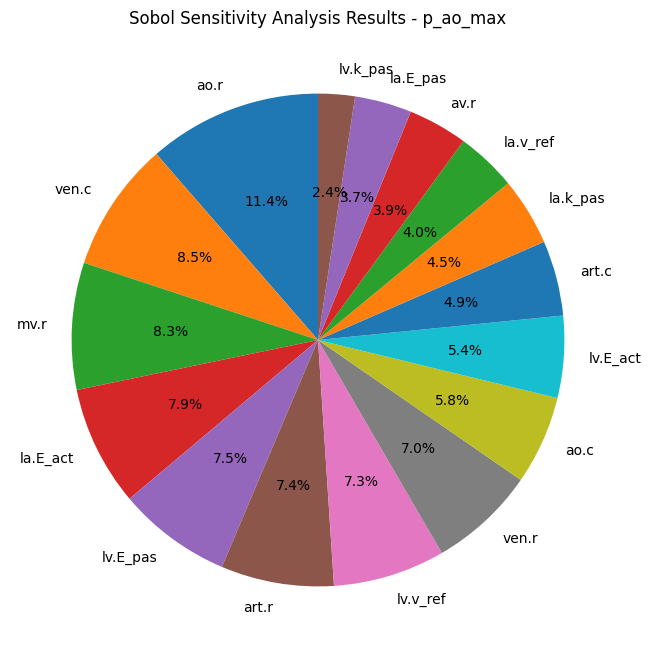

Top 3 most sensitive parameters:
  1. ao.r: 1.820
  2. ven.c: 1.365
  3. mv.r: 1.331


In [123]:
import matplotlib.pyplot as plt

# Use the already sorted ST DataFrame
labels = ST.index
sizes = ST['ST']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f'Sobol Sensitivity Analysis Results - {output_feature}')
plt.show()

# Print summary
print(f"Top 3 most sensitive parameters:")
for i in range(min(3, len(ST))):
    print(f"  {i+1}. {ST.index[i]}: {ST['ST'].iloc[i]:.3f}")